In [9]:
import numpy as np
import tensorflow as tf
from glob import glob
import IPython
import time
import librosa
import os
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torchaudio

# Generate spectrograms

In [10]:
hop=256               #hop size (window size = 4*hop)
sr=16000             #sampling rate
n_mels= hop
n_stft= (513-1)*2
min_level_db=-100     #reference values to normalize data
ref_level_db=20


shape=128           #length of time axis of split specrograms         
spec_split=1

In [11]:
import torch
from torchaudio.transforms import MelScale, Spectrogram, MelSpectrogram

torch.set_default_tensor_type('torch.FloatTensor')

melspecobj = MelSpectrogram(n_fft=4*hop, win_length=4*hop, hop_length=hop, pad=0, power=2, normalized=False, n_mels=hop)
mel_specfunc = melspecobj.forward

def melspecfunc(waveform):
  mel_specgram = mel_specfunc(waveform)
  return mel_specgram

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def prep(wv, hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)


/home/kobemoerman/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [12]:
#Generate spectrograms from waveform array
def tospec(data):
  spectro = []
  for awv in data:
    spec = prep(awv)
    spectro.append(spec)
  return np.array(spectro, dtype=np.float32)
    

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)

    time = 1
    length = len(x)/sr

    while time < length:
      adata.append(x[(time-1)*sr:time*sr])
      time += 1

  return np.array(adata)

In [14]:
audio_directory = "./Dataset/wav/female"
array_file = './Dataset/array/female'

#get waveform array from folder containing wav files
awv = audio_array(audio_directory)

#get spectrogram array
aspec = tospec(awv)

print(aspec.shape)

np.save(array_file,aspec)

(2822, 256, 63)


# Compare results

torch.Size([1, 53680])
Sample Rate: 16000
Shape: (1, 53680)
Dtype: torch.float32
 - Max:      0.629
 - Min:     -0.650
 - Mean:    -0.000
 - Std Dev:  0.114

tensor([[-0.0021, -0.0026, -0.0025,  ...,  0.0000,  0.0000,  0.0000]])



<Figure size 432x288 with 0 Axes>

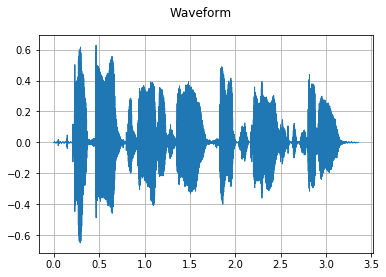

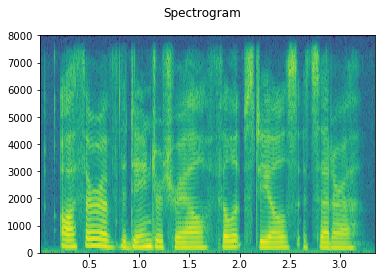

In [15]:
from utils import print_stats, plot_waveform, plot_specgram_from_wave, plot_specgram
import torchaudio

SAMPLE_WAV_SPEECH_PATH = "./Dataset/wav/female/arctic_a0001.wav"


waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
print(np.shape(waveform))
plt.clf()
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram_from_wave(waveform, sample_rate)

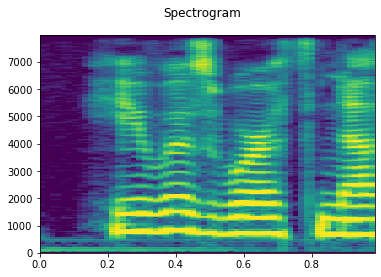

In [16]:
plot_specgram(aspec[0], sample_rate=sr)

In [27]:
import soundfile as sf

audio = librosa.feature.inverse.mel_to_audio(aspec[3])

# export as wav file
# audio = torch.tensor(audio)
# torchaudio.save("audio.wav", aspec[0], sample_rate=sr)
sf.write('file.wav', data=awv[3], samplerate=sr)
sf.write('mel.wav', data=audio, samplerate=sr)
# librosa.output.write_wav("audio.wav",audio,22050)